# ML-model verification with z3
In this tutorial, the first step is to implement a machine learning model for image recognition using the python library pytorch. In the second step, the model is verified using the SMT solver z3.

Using pip, the z3 solver is downloaded and the required parts are imported from pytorch.

In [ ]:
!nvidia-smi
!pip install z3-solver

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.datasets import load_iris

Wed May 11 09:34:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get Dataset

Training and test data must be available to train the ML model. These are downloaded from a public library and extracted via a DataLoader. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
# print(iris_dataset)

X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']
  
print(f"Shape of X (data): {X.shape}")
print(f"Shape of y (target): {y.shape} {y.dtype}")
print(f"Example of x and y pair: {X[0]} {y[0]}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

Shape of X (data): (150, 4)
Shape of y (target): (150,) int64
Example of x and y pair: [5.1 3.5 1.4 0.2] 0


# Visualize

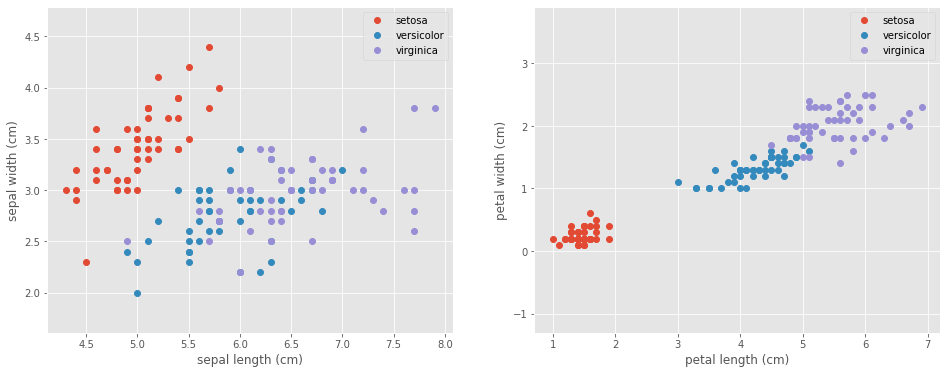

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

## Create Model

The class NeuralNetwork(nn.Module) allows initializing a neural network with different layers. 
Here, we use a simple network with only two linear layers, because complex networks as complex networks require a high computational effort for verification.

In [ ]:
import torch.nn.functional as F
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

An instance of the class NeuralNetwork() is then created and trained by using an optimizer and loss function.

In [ ]:
model = NeuralNetwork()   #.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

import tqdm
from torch.autograd import Variable
import numpy as np

EPOCHS  = 100
X_train_tensor = Variable(torch.from_numpy(X_train)).float()
y_train_tensor = Variable(torch.from_numpy(y_train)).long()
X_test_tensor  = Variable(torch.from_numpy(X_test)).float()
y_test_tensor = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        correct = (torch.argmax(y_pred, dim=1) == y_test_tensor).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

print(model)
print(accuracy_list)

Using cuda device


100%|██████████| 100/100 [00:00<00:00, 527.31it/s]


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=3, bias=True)
  )
)
[0.         0.         0.         0.         0.         0.03333334
 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334 0.03333334
 0.03333334 0.03333334 0.03333334 0.06666667 0.06666667 0.1
 0.1        0.1        0.1        0.13333334 0.16666667 0.23333333
 0.23333333 0.23333333 0.30000001 0.30000001 0.36666667 0.36666667
 0.46666667 0.53333336 0.53333336 0.53333336 0.53333336 0.63333333
 0.63333333 0.63333333 0.69999999 0.76666665 0.76666665 0.76666665
 0.76666665 0.76666665 0.76666665 0.76666665 0.76666665 0.76666665
 0.76666665 0.76666665 0.80000001 0.83333331 0.83333331 0.83333331
 0.86666667 0.86666667 0.86666667 0.86666667 0.86666667 0.86666667
 0.86666667 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998 0.89999998
 0.89999998 0

# Create Solver to find Adversarial Examples

The next step will be to create a solver with z3 in order to find Aversarial Examples. "An adversarial example is an instance with small, intentional feature perturbations that cause a machine learning model to make a false prediction." (For more information on adversarial examples see [this article](https://christophm.github.io/interpretable-ml-book/adversarial.html).
Z3 is a theorem prover from Microsoft Research (for more information on z3 see [z3 on pypi](https://pypi.org/project/z3-solver/)). 

We first need to import the numpy and z3 library.

In [ ]:
import numpy as np
from z3 import *

The ML model was trained on the MNIST dataset in the previous section.
Now the task is to recreate the model using the trained weights and the layers of the model. To do this, the learned weights and biases must first be extracted from the model. This is done by iterating over the layers and saving the weights and biases of the Linear Layers into lists.

In [ ]:
# get weights and biases
weights = list()
biases = list()

for child in model.children():
    if isinstance(child, nn.Sequential):
        for layer in child.children():
            if isinstance(layer, nn.Linear):
              weights.append(layer.weight.data)
              biases.append(layer.bias.data)

To analyze the network with z3 later on, we have to manually define our activation function which in our case is the Relu function as our solver can only deal with (partially) linear activation functions. In the same way the absolute value is defined as a helper function to aid in calculating the distance between 2 vectors when using z3.

In [ ]:
def Relu(x):
    return np.vectorize(lambda y: If(y >= 0 , y, RealVal(0)))(x)


def Abs(x):
    ret = If(x <= 0, -x, x)
    return ret

In the following function the model is defined. 
The input x are z3 variables. They iterate through each layer with the previously extracted weights and biases. 
This results in a z3 formula with the z3 inputs.

In [ ]:
def net(x):
    if len(weights) is not len(biases):
        raise RuntimeError("List of weights and biases must have same length.")
    num_layers = len(weights)
    x1 = x @ np.transpose(weights[0].cpu().detach().numpy()) + biases[0].cpu().detach().numpy()
    y1 = Relu(x1)
    x2 = y1 @ np.transpose(weights[1].cpu().detach().numpy()) + biases[1].cpu().detach().numpy()
    return x2

In the next section we search the adversarial example to a sample of the dataset. Therefore a sample runs through the trained model to predict an outcome. 
The beforehand written function ```net(x)``` gets a manipulated input of the sample. A epsilon is added to every value of the input of the function.
To generate a vector epsilon which will constitute our manipulation of the input data with z3 the solver has to be defined first and then the constraints of our vectors as well as the inputs and outputs are added to the solver. The solver then has to check the satisfiability of the given constraints and a model is returned and printed if a vector epsilon which has a taxicab norm smaller than the constant e and changes the category with the highest probability exists.

In [ ]:
def find_adversarial_example(num, s):
   # predict outcome of inputs with network
    sample = Variable(torch.from_numpy(X_test[num])).float()
    y1 =  torch.argmax(model(sample)).tolist()
    if (y1 == y_test[num]):
      print("The ML model predicted the correct flower.")
    else:
      print("The ML model predicted the wrong flower, for a correct example rerun the script.")

    epsilon = RealVector('epsilon', 4)
    # new sample with a little difference e (adversarial example)
    new_X = [x + e for (x, e) in zip(sample.cpu().detach().numpy(), epsilon)]
    y2_pred = net(new_X)

    s.push()
    e = 1
    s.add(Sum([Abs(a) for a in epsilon]) < e)
    # does work :
    # s.add(torch.argmax(y1).cpu().detach().numpy() != y2_pred)
    s.add(Or(y2_pred[0] > y2_pred[y1], y2_pred[1] > y2_pred[y1], y2_pred[2] > y2_pred[y1]))
    res = s.check()
    print(res)
    if res == sat:
        m = s.model()
        print(m)
    s.pop()




In [ ]:
for i in range(len(X_test)):
  s = Solver()
  find_adversarial_example(i, s)

The ML model predicted the correct flower.
unsat
The ML model predicted the correct flower.
unsat
The ML model predicted the correct flower.
sat
[epsilon__0 = 172616485348679837844902620781392844994382335035530543448360938691/14937691951199917571417023207927580249108822043278850000000000000000,
 epsilon__3 = 172616485348679837844902620781392844994382335035530543448360938691/14937691951199917571417023207927580249108822043278850000000000000000,
 epsilon__1 = -2525619300569443532343809499480524718913105874040193790522958277243/9336057469499948482135639504954737655693013777049281250000000000000,
 epsilon__2 = 172616485348679837844902620781392844994382335035530543448360938691/14937691951199917571417023207927580249108822043278850000000000000000]
The ML model predicted the correct flower.
sat
[epsilon__0 = 41211004452497590087872976394637933487412606625079/5224691051235432080096971231112553520000000000000000,
 epsilon__3 = 41211004452497590087872976394637933487412606625079/5224691051235432080